In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

# Aula 09 - Molécula de Água e Campos de Força

## Topologia da Molécula de Água

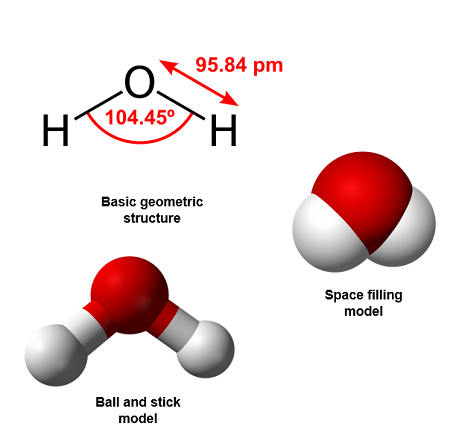

Definindo a topologia da molécula de água H-O-H

In [3]:
mol_topology = Topology()
chain = mol_topology.addChain()
residue = mol_topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = mol_topology.addAtom("O", element_O, residue)
atom1 = mol_topology.addAtom("H", element_H, residue)
atom2 = mol_topology.addAtom("H", element_H, residue)
mol_topology.addBond(atom0, atom1)
mol_topology.addBond(atom0, atom2)

In [4]:
print(mol_topology)
print("Número de átomos:", mol_topology.getNumAtoms())
for iatom, atom in enumerate(mol_topology.atoms()):
    print(f"Nome e massa do átomo {iatom}: {atom.name}, {atom.element.mass}")

<Topology; 1 chains, 1 residues, 3 atoms, 2 bonds>
Número de átomos: 3
Nome e massa do átomo 0: O, 15.99943 Da
Nome e massa do átomo 1: H, 1.007947 Da
Nome e massa do átomo 2: H, 1.007947 Da


## Campos de Força Gerais

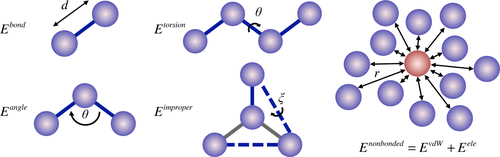

## Termos Ligantes

### 1. Termo de Comprimento da ligação

$$U_\text{bond} = \frac{k_l}{2}(l - l_0)^2$$

Para água, no TIP3, temos 
- $l_0=0.09572$ nm
- $k_l=462750.4$ kJ/(nm $^2$ mol) 

### 2. Termo de ângulo de ligação

$$ U_{\text{angle}} = \frac{k_\theta}{2}(\theta-\theta_0)^2$$

Para água no TIP3 temos 
- $\theta_0=1.82421813418$ rad
- $k_\theta = 836.8$ kJ/mol

### 3. Termo de torção

$$ U_\text{torcao} = \frac{k_\text{torcao}}{2}\cos(n\phi-\phi_0)$$

## Termos Não-ligantes

### 1. Dispersão de van der Waals

$$ U_\text{vdW} = \frac{A_{ij}}{r_{ij}^{12}} - \frac{B_{ij}}{r_{ij}^6}$$

### 2. Interação eletrostática

$$ U_\text{ele} = \frac{q_i q_j}{4\pi \epsilon r_{ij}}$$

Escolhendo o campo de força para a água

In [5]:
forcefield = ForceField('amber14/tip3p.xml')

Definindo o sistema para simulação 

In [ ]:
system = forcefield.createSystem(mol_topology, nonbondedCutoff=1 * nanometer)

platform = Platform.getPlatformByName('CPU') # ou 'CUDA' se tiver GPU

# c. Definition an integrator, mandatory.
integrator = VerletIntegrator(1 * femtoseconds)

# d. A simulation object in OpenMM combines topology, system and integrator.
simulation = Simulation(mol_topology, system, integrator, platform)

# Definindo a geometria inicial da molécula
bond = 0.9572  # Å
angle = 1.82421813418 # rad (104.52° in radians)
simulation.context.setPositions(
    np.array([
    [0.0,         0.0,         0.0        ],  # O
    [ bond,       0.0,         0.0        ],  # H1
    [ bond*np.cos(angle), bond*np.sin(angle), 0.0 ],  # H2
]) * angstrom
)

In [7]:
force = system.getForce(0)
print("Parâmetros da força de ligação O-H:")
for i in range(force.getNumBonds()):
    l = force.getBondParameters(i)
    print(f"Parâmetro {i}: {l}")

print()
force_angle = system.getForce(3)
print("Parâmetros da interação de ângulo H-O-H:")
for i in range(force_angle.getNumAngles()):
    theta = force_angle.getAngleParameters(i)
    print(f"Parâmetro {i}: {theta}")

Parâmetros da força de ligação O-H:
Parâmetro 0: [0, 1, Quantity(value=0.09572, unit=nanometer), Quantity(value=462750.4, unit=kilojoule/(nanometer**2*mole))]
Parâmetro 1: [0, 2, Quantity(value=0.09572, unit=nanometer), Quantity(value=462750.4, unit=kilojoule/(nanometer**2*mole))]

Parâmetros da interação de ângulo H-O-H:
Parâmetro 0: [1, 0, 2, Quantity(value=1.82421813418, unit=radian), Quantity(value=836.8, unit=kilojoule/(mole*radian**2))]


## Cálculo de Energia de comprimento da ligação O-H na molécula de H2O

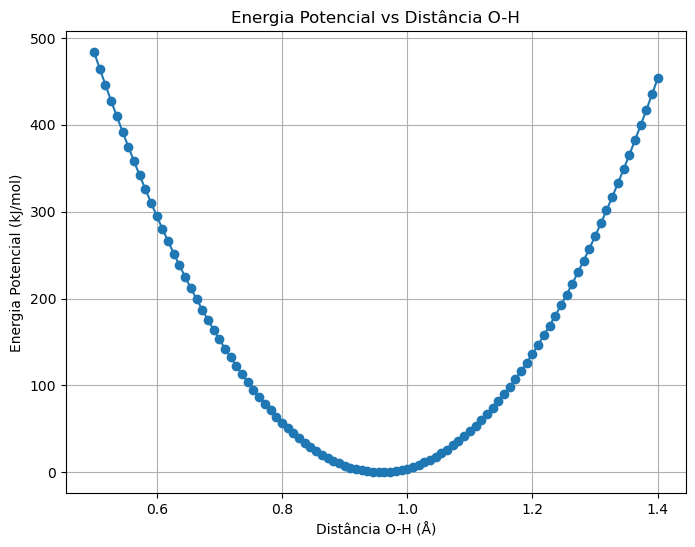

In [8]:
# loop sobre distancias entre o átomo de oxigênio e o hidrogênio 1 e calcula a energia potencial
distances = np.linspace(0.5, 1.4, 100) * angstrom
energies = []
for distance in distances:
    simulation.context.setPositions(
        np.array([
            [0.0, 0.0, 0.0],  # O
            [distance.value_in_unit(angstrom), 0.0, 0.0],  # H1
            [bond * np.cos(angle), bond * np.sin(angle), 0.0]  # H2
        ]) * angstrom
    )
    state = simulation.context.getState(getEnergy=True)
    energies.append(state.getPotentialEnergy().value_in_unit(kilojoule_per_mole))
    
# Convertendo as energias para um array NumPy
energies = np.array(energies)


# Criando um gráfico de energia potencial versus distância
plt.figure(figsize=(8, 6))
plt.plot(distances.value_in_unit(angstrom), energies, marker='o', linestyle='-', color='C0')
plt.title('Energia Potencial vs Distância O-H')
plt.xlabel('Distância O-H (Å)')
plt.ylabel('Energia Potencial (kJ/mol)')
plt.grid()


## Cálculo de Energia de ângulo da ligação H-O-H na molécula de H2O

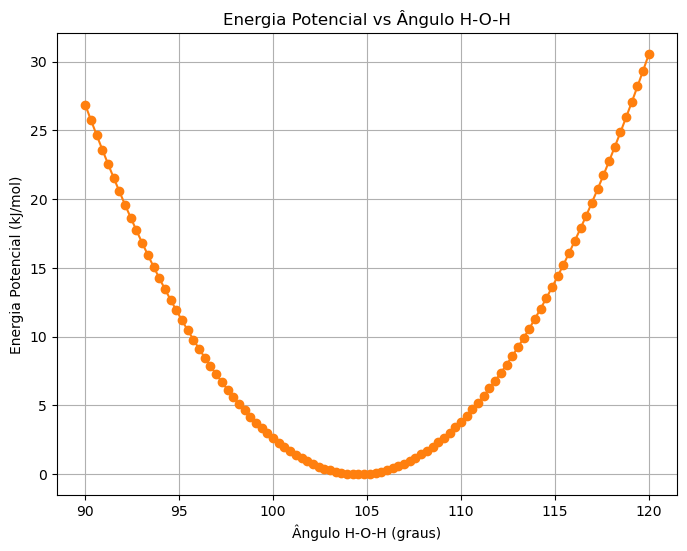

In [9]:
# loop sobre valores do ângulo entre H-O-H e calcula a energia potencial
angles = np.linspace(90, 120, 100) * np.pi / 180  # Ângulos de 90 a 150 graus
energies_angle = []
for angle in angles:
    simulation.context.setPositions(
        np.array([
            [0.0, 0.0, 0.0],  # O
            [bond, 0.0, 0.0],  # H1
            [bond * np.cos(angle), bond * np.sin(angle), 0.0]  # H2
        ]) * angstrom
    )
    state = simulation.context.getState(getEnergy=True)
    energies_angle.append(state.getPotentialEnergy().value_in_unit(kilojoule_per_mole))

# Convertendo as energias para um array NumPy
energies_angle = np.array(energies_angle)

# Criando um gráfico de energia potencial versus ângulo
plt.figure(figsize=(8, 6))
plt.plot(np.degrees(angles), energies_angle, marker='o', linestyle='-', color='C1')
plt.title('Energia Potencial vs Ângulo H-O-H')
plt.xlabel('Ângulo H-O-H (graus)')
plt.ylabel('Energia Potencial (kJ/mol)')
plt.grid()


## Cálcula o equilíbrio da molécula

Posições antes do equilíbrio

In [10]:
# Definindo a geometria inicial da molécula
bond = 0.95  # Å
angle = 105.0 * np.pi/180
simulation.context.setPositions(
    np.array([
    [0.0,         0.0,         0.0        ],  # O
    [ bond,       0.0,         0.0        ],  # H1
    [ bond*np.cos(angle), bond*np.sin(angle), 0.0 ],  # H2
]) * angstrom
)

state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
print("Energia potencial: ", state.getPotentialEnergy())
print()
print("Posições Atômicas")
print(state.getPositions(asNumpy=True))
print()

Energia potencial:  0.26925569772720337 kJ/mol

Posições Atômicas
[[ 0.          0.          0.        ]
 [ 0.095       0.          0.        ]
 [-0.02458781  0.09176295  0.        ]] nm



Minimiza a energia da molécula de acordo com o campo de força TIP3

In [11]:
simulation.minimizeEnergy()

Posições e infos após o equilíbrio da molécula

In [12]:
state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
print("Energia potencial: ", state.getPotentialEnergy())
print()
print("Posições Atômicas")
print(state.getPositions(asNumpy=True))
print()

Energia potencial:  9.281799329130536e-09 kJ/mol

Posições Atômicas
[[-3.06727074e-04 -3.99716635e-04  0.00000000e+00]
 [ 9.54123214e-02  1.15921341e-06  0.00000000e+00]
 [-2.46934034e-02  9.21615064e-02  0.00000000e+00]] nm



Calcula distancia O-H e ângulo H-O-H de equilíbrio

In [13]:
# comprimento O-H, em nanometros.
eq_pos = state.getPositions(asNumpy=True)
l0 = np.linalg.norm(eq_pos[1] - eq_pos[0])
print('Comprimento da Ligação O-H: ',l0,  'nm')

# ângulo H-O-H
d01 = eq_pos[1] - eq_pos[0]
d02 = eq_pos[2] - eq_pos[0]
d01 /= np.linalg.norm(d01)
d02 /= np.linalg.norm(d02)
cosine = np.dot(d01, d02)
theta0 = np.arccos(cosine)
print('Ângulo da Ligação H-O-H: ', theta0, 'rad, ',np.degrees(theta0), 'graus')

Comprimento da Ligação O-H:  0.0957198879020557 nm
Ângulo da Ligação H-O-H:  1.8242195531644219 rad,  104.52008130156227 graus


---

# Dinâmica Molecular com Água

Definição da caixa de simulação 

In [14]:
L = 30 * angstrom

box_matrix = L * np.identity(3)
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)

N_mol = 1000

resname = next(mol_topology.residues()).name

for i in range(N_mol):
    chain   = topology.addChain()
    residue = topology.addResidue(resname, chain)
    atom_map = {}  

    # 1) add atoms
    for atom in mol_topology.atoms():
        new = topology.addAtom(atom.name, atom.element, residue)
        atom_map[atom] = new

    # 2) add the same bonds
    for bond in mol_topology.bonds():
        a1 = atom_map[bond.atom1]
        a2 = atom_map[bond.atom2]
        topology.addBond(a1, a2)

Colocando cada molécula em um lugar distinto da caixa

In [15]:
# Coloca cada molécula em uma posição aleatória dentro da caixa cúbica

all_pos = []
for _ in range(N_mol):
    CMpos = np.random.uniform(0, L / nanometer, 3)
    coords = CMpos + eq_pos/nanometer
    all_pos.append(coords)

Definindo integrador para simulação NVT

In [16]:
temperatura = 300 * kelvin

system = forcefield.createSystem(topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

integrator = LangevinMiddleIntegrator(temperatura, 1/picosecond, 4*femtoseconds)

simulation = Simulation(topology, system, integrator,platform)
simulation.context.setPositions(np.vstack(all_pos) * angstrom)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperatura)

In [17]:
positions = simulation.context.getState(getPositions=True).getPositions()

PDBFile.writeFile(topology, positions, open('initial_water.pdb', 'w'))

Definindo os relatórios

In [18]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("output_water.dcd", 1000))

# Escreve num arquivo csv a cada 20 passos 
simulation.reporters.append(
    StateDataReporter(
        "md_log_water.csv",
        20,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, totalEnergy=True,temperature=True,
        volume=True)
)

Equilibração NVT

In [19]:
print("Equilibrando com NVT")

simulation.step(5000)

Equilibrando com NVT
#"Step","Total Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-31768.745983878674,301.9352607546402,27.0
2000,-31380.973629624175,308.58556263029186,27.0
3000,-31493.572923302243,300.7156705039631,27.0
4000,-31257.166449616954,307.8481586073012,27.0
5000,-30855.938516956347,311.4572792114003,27.0


## Produção NPT

In [20]:
pressao = 1*bar

system.addForce(MonteCarloBarostat(pressao, temperatura))
simulation.context.reinitialize(preserveState=True)


print("Rodando NPT")
simulation.step(70000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

Rodando NPT
6000,-31364.201813943102,289.01566110125947,28.719890799466537
7000,-30840.29813021727,300.57139076524595,29.261768051655995
8000,-30850.16621089648,300.99254850467776,29.475919164027975
9000,-30870.903355176095,296.6544006486908,30.03932603125926
10000,-30295.999728063412,310.2633426884965,30.560367466444117
11000,-30893.45016205494,299.5649983314473,29.624219348877645
12000,-30515.6174795946,299.71003935372823,30.320167339383637
13000,-30676.25872015505,299.18443593603797,30.33386270728894
14000,-30765.341874362668,306.62624951626805,30.034525994053098
15000,-30421.029764608655,307.14400189595574,30.089058661325804
16000,-30914.994258195657,295.5242033021201,30.482311322987012
17000,-30606.29718896307,304.3689739809364,30.251351865478725
18000,-30662.883799547068,302.8189137155572,29.94157593532929
19000,-30686.554052081745,302.86752654002584,30.022120358515505
20000,-30876.441890192684,301.2156886711479,29.94149794628836
21000,-30811.432675431162,299.69406994452714,30.13

## Análise dos dados

In [21]:
traj = mdtraj.load("output_water.dcd", top="initial_water.pdb")
view = nglview.show_mdtraj(traj, width='600px', height='400px')
view.clear_representations()

# show all atoms as small spheres
# view.add_spacefill(selection='all', radius=0.3)

# or, if your water residues are named HOH/resname WATER:
view.add_ball_and_stick(selection='resname water')

#centralizado
view.center(selection='all')

# add box
view.add_unitcell()
view

NGLWidget(max_frame=74)

In [22]:
df = pd.read_csv("md_log_water.csv")

In [23]:
df.head()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Box Volume (nm^3)
0,20,0.08,-40903.897987,-32806.467029,278.375616,27.0
1,40,0.16,-41367.847328,-33145.375160,282.674315,27.0
2,60,0.24,-41113.298622,-32803.438671,285.678555,27.0
3,80,0.32,-41177.137916,-32881.709939,285.182409,27.0
4,100,0.40,-41395.138404,-32873.251580,292.967671,27.0


In [24]:
df['Total Energy (kJ/mole)']

0      -32806.467029
1      -33145.375160
2      -32803.438671
3      -32881.709939
4      -32873.251580
            ...     
3745   -31268.000127
3746   -31311.828146
3747   -31159.340430
3748   -31042.664858
3749   -30926.214449
Name: Total Energy (kJ/mole), Length: 3750, dtype: float64

Text(0, 0.5, 'Volume (nm$^3$)')

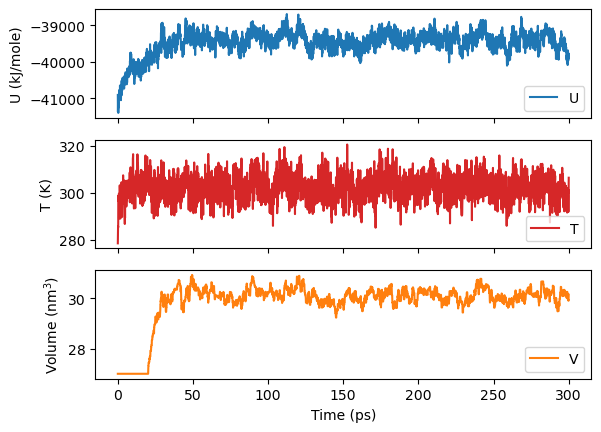

In [25]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C0',label='U')
axs[0].legend(loc='best')
axs[0].set_ylabel('U (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[1].legend(loc='best')
axs[1].set_ylabel('T (K)')

axs[2].plot(df['Time (ps)'],df['Box Volume (nm^3)'],color='C1',label='V')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('Volume (nm$^3$)')

In [26]:
timecut = 50

In [27]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > timecut]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > timecut]
subsetV = df['Box Volume (nm^3)'][df['Time (ps)'] > timecut]

In [28]:
from IPython.display import display, Math


# Cálculo da média e desvio padrão da energia potencial U
Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

<IPython.core.display.Math object>

In [29]:
# Cálculo da média e desvio padrão da temperatura T
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

In [30]:
# Cálculo da média e desvio padrão do volume V
Vmean = subsetV.mean()
sigmaV = subsetV.std()

display(Math(rf"$V = {Vmean:.2f} \pm {sigmaV:.2f}\ nm^3"))

<IPython.core.display.Math object>

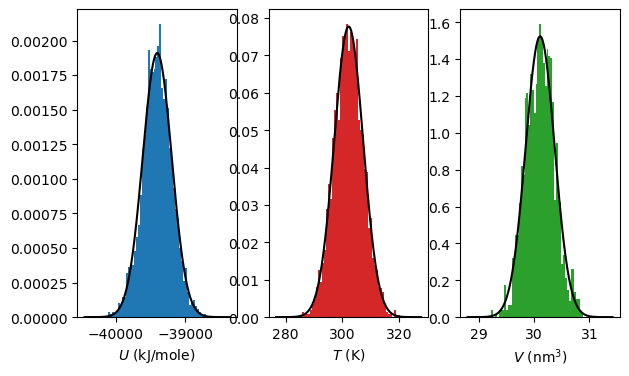

In [31]:
# Gráfico de histogramas com as distribuições de U, T e V
fig, axs = plt.subplots(1, 3,figsize=(7,4))

axs[0].hist(subsetU,bins=50,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=50,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

axs[2].hist(subsetV,bins=50,density=True,color='C2')
axs[2].set_xlabel(r'$V$ (nm$^3$)')

Varray = Vmean + np.arange(-5*sigmaV,5*sigmaV,0.01*sigmaV)
axs[2].plot(Varray,np.sqrt(1/(2*np.pi*sigmaV**2))*np.exp(-0.5*(Varray-Vmean)**2/sigmaV**2),color='k')

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> - Calcule a densidade da água para essa $T=300$ K e $P = 1$ bar e compare com o valor tabelado pelo NIST em $55315$ mol/m^3. 
> - Estime a incerteza no valor da densidade calculada.
> - Repita o cálculo agora com 500 partículas de água na caixa. A incerteza aumentou ou diminuiu? Por quanto?

In [32]:
# Cálculo da densidade de moléculas a T = 300 K e P = 1 bar
nmean = (N_mol/ 6.022e23) / (Vmean * 1e-27)
print(f"Densidade simulada: {nmean:.2f} mol/m³")

Densidade simulada: 55151.03 mol/m³


In [33]:
# Valor experimental da densidade de água a 300 K e 1 bar
nexp = 55315 # mol/m^3
print(f"Densidade experimental: {nexp} mol/m³")

Densidade experimental: 55315 mol/m³


In [34]:
# Desvio percentual da densidade simulada em relação à densidade experimental
desvio_percentual = np.abs((nmean - nexp) / nexp) * 100
print(f"Desvio percentual: {desvio_percentual:.2f}%")

Desvio percentual: 0.30%


In [35]:
# Cálculo da incerteza da densidade simulada
sigma_n = nmean * sigmaV / Vmean
print(f"Densidade simulada: {nmean:.2f} ± {sigma_n:.2f} mol/m³")

Densidade simulada: 55151.03 ± 479.79 mol/m³


In [ ]:
# Simulação da densidade de água a 300 K e 1 bar com 500 moléculas

# 0. Define as variáveis do sistema molecular
N_mol = 500
L = 25 * angstrom # tamanho inicial da caixa cúbica
temperatura = 300 * kelvin # temperatura em Kelvin
pressao = 1*bar # pressão em bar

## 1. Define a topologia da água
print("Criando a topologia da água")
mol_topology = Topology()
chain = mol_topology.addChain()
residue = mol_topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = mol_topology.addAtom("O", element_O, residue)
atom1 = mol_topology.addAtom("H", element_H, residue)
atom2 = mol_topology.addAtom("H", element_H, residue)
mol_topology.addBond(atom0, atom1)
mol_topology.addBond(atom0, atom2)

bond = 0.9572  # Å
angle = 1.82421813418 # rad (104.52° in radians)
eq_pos = (
    np.array([
    [0.0,         0.0,         0.0        ],  # O
    [ bond,       0.0,         0.0        ],  # H1
    [ bond*np.cos(angle), bond*np.sin(angle), 0.0 ],  # H2
]) * angstrom
)

## 2. Define a topologia da caixa com moléculas de água
print("Criando a topologia da caixa com moléculas de água")
box_matrix = L * np.identity(3)
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
resname = next(mol_topology.residues()).name
for i in range(N_mol):
    chain   = topology.addChain()
    residue = topology.addResidue(resname, chain)
    atom_map = {}  
    for atom in mol_topology.atoms():
        new = topology.addAtom(atom.name, atom.element, residue)
        atom_map[atom] = new
    for bond in mol_topology.bonds():
        a1 = atom_map[bond.atom1]
        a2 = atom_map[bond.atom2]
        topology.addBond(a1, a2)

all_pos = []
for _ in range(N_mol):
    CMpos = np.random.uniform(0, L / nanometer, 3)
    coords = CMpos + eq_pos/nanometer
    all_pos.append(coords)

## 3. Define o campo de força e o sistema
print("Escolhendo o campo de força e criando o sistema")
forcefield = ForceField('amber14/tip3p.xml')
platform = Platform.getPlatformByName('CPU')  # ou 'CUDA' se tiver GPU
system = forcefield.createSystem(topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

## 4. Define o integrador e a temperatura
integrator = LangevinMiddleIntegrator(temperatura, 1/picosecond, 4*femtoseconds)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(np.vstack(all_pos) * angstrom)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperatura)

simulation.reporters = []
simulation.reporters.append(
    StateDataReporter(
        "md_log_water.csv",
        20,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
        volume=True
    )
)
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True,time=True, totalEnergy=True,temperature=True,
        volume=True)
)
print("Equilibrando com NVT")
simulation.step(5000)

## 5. Adiciona o barostato e realiza produção NPT
system.addForce(MonteCarloBarostat(pressao, temperatura))
simulation.context.reinitialize(preserveState=True)
print("Rodando NPT")
simulation.step(70000)
del simulation

## 6. Carrega os dados, analisa o volume médio e calcula a densidade
print("Carregando os dados e calculando a densidade")
df = pd.read_csv("md_log_water.csv")
subsetV = df['Box Volume (nm^3)'][df['Time (ps)'] > 50.0]
Vmean = subsetV.mean() # em nm³
sigmaV = subsetV.std()
nmean = (N_mol/ 6.022e23) / (Vmean * 1e-27)
sigman = nmean * sigmaV / Vmean
print(f"Densidade de moléculas: {nmean:.2f} ± {sigman:.2f} mol/m³")
Mm = 18.01528  # g/mol
densidade = nmean * Mm / 1000  # g/L
sigma_densidade = sigman * Mm / 1000  # Cálculo da incerteza da densidade simulada g/L
print(f"Densidade de massa: {densidade:.2f} ± {sigma_densidade:.2f} g/L")

Criando a topologia da água
Criando a topologia da caixa com moléculas de água
Escolhendo o campo de força e criando o sistema
Equilibrando com NVT
#"Step","Time (ps)","Total Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,4.000000000000003,-15631.479456465779,303.07861482539033,15.625
2000,7.999999999999562,-15400.34271299289,305.6591082605302,15.625
3000,11.999999999999122,-15456.027222734032,289.48716196877285,15.625
4000,15.999999999998682,-15104.932072261901,306.2309085794288,15.625
5000,20.000000000000018,-14962.352908420464,305.11727333774854,15.625
Rodando NPT
6000,24.000000000001354,-15122.778751598089,309.5310142520339,14.800680185823893
7000,28.00000000000269,-15521.305896836042,290.77904699134655,14.778316368021544
8000,32.00000000000402,-15073.603834230147,310.72205251711756,15.140895295541917
9000,36.000000000001805,-15197.109786155372,301.9305361339642,15.051762475588554
10000,39.99999999999959,-15375.847684544278,301.0110992630675,15.10955426874944
11000,43

BONUS: Análise da incerteza com respeito ao número de moléculas na caixa 

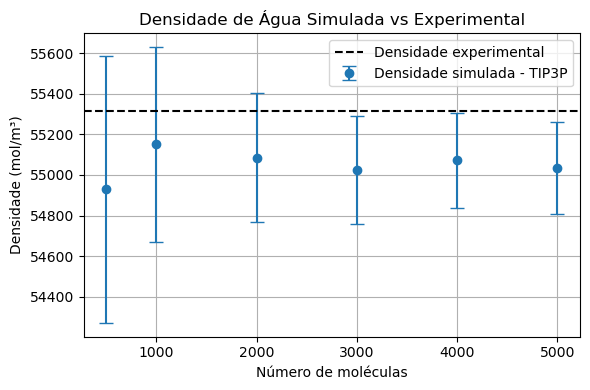

In [74]:
number_of_molecules = np.array([500, 1000, 2000, 3000, 4000, 5000])
density = np.array([54929.37,55151.03,55086.23,55022.79,55071.59,55035.42])
density_error = np.array([659.29, 479.79,320.27,266.33,235.66,226.33])  

plt.figure(figsize=(6, 4))
plt.errorbar(number_of_molecules, density, yerr=density_error, fmt='o', capsize=5, color='C0', label='Densidade simulada - TIP3P')
plt.axhline(y=55315, color='k', linestyle='--', label='Densidade experimental')
plt.xlabel('Número de moléculas')
plt.ylabel('Densidade (mol/m³)')
plt.title('Densidade de Água Simulada vs Experimental')
plt.legend()
plt.grid()
plt.tight_layout()